## Vehicle Detection Project

The goals / steps of this project are the following:


* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
 
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.

* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


---

In [205]:
# Imports
import cv2
import os
import glob
import time
import numpy as np
import pickle

from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage.feature import hog
from scipy.ndimage.measurements import label

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

%matplotlib inline

In [206]:
# Helper Function to illustrate processing methods

# Illustrate two images
def plot_side_by_side(img1, img2, cap1, cap2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(cap1, fontsize=12)
    ax2.imshow(img2)
    ax2.set_title(cap2, fontsize=12)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
# Randomly plot 16 images
def plot_multi(img_list):
    f, ax = plt.subplots(4, 4, figsize=(8, 8))
    ax=ax.ravel()
    f.tight_layout()
    for i in range(16):
        img = cv2.imread(img_list[np.random.randint(0,len(img_list))])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        ax[i].axis('off')
        ax[i].imshow(img)
        
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## 1. Load Training Data

In [207]:
# Read in cars and notcars from Datasets
cars = []
notcars = []

images = glob.glob('data/non-vehicles/*.png',recursive=True)
for image in images:
    notcars.append(image)
print("I have found "+str(len(notcars))+" background images...")

images = glob.glob('data/vehicles/**/*.png',recursive=True)
for image in images:
    cars.append(image)
print("I have found "+str(len(cars))+" car images...")

I have found 8968 background images...
I have found 8792 car images...


### Visualize Training Images

======================================== Plotting Random Cars ========================================


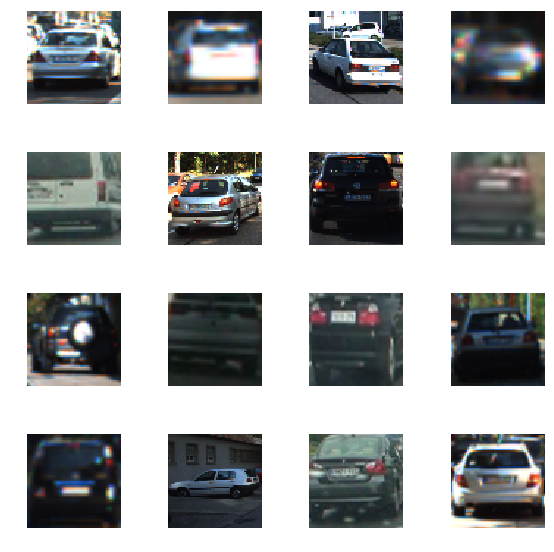

======================================== Plotting Random Background ========================================


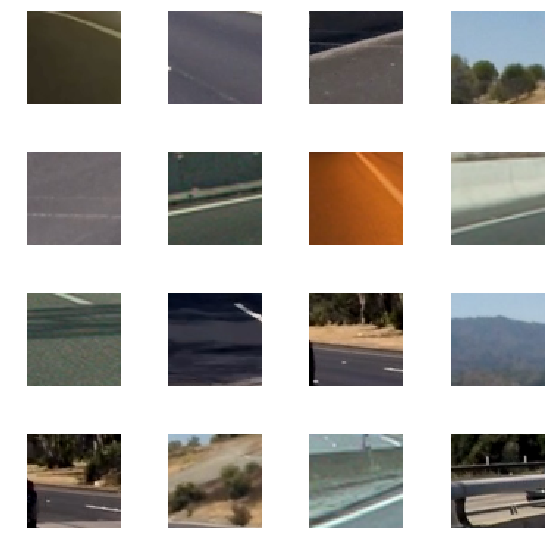

In [208]:
print("="*40, "Plotting Random Cars", "="*40)
plot_multi(cars)
plt.show()

print("="*40, "Plotting Random Background", "="*40)
plot_multi(notcars)

## 2. Histogram of Oriented Gradients (HOG) feature extraction
### Define HOG feature function

In [209]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### Visualize HOG

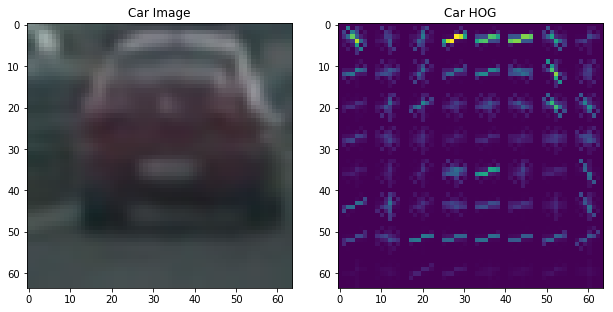

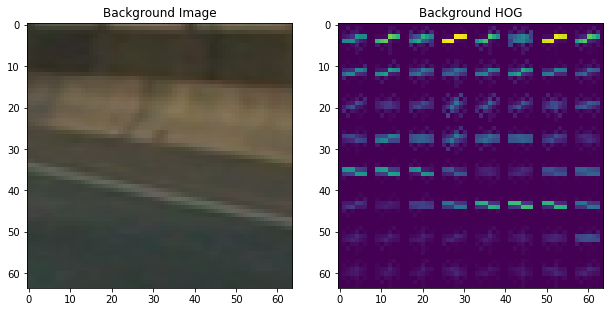

In [210]:
car_img = mpimg.imread(cars[np.random.randint(0,len(cars))])
feat, car_hog = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True)

notcar_img = mpimg.imread(notcars[np.random.randint(0,len(notcars))])
feat, notcar_hog = get_hog_features(notcar_img[:,:,2], 9, 8, 8, vis=True)

plot_side_by_side(car_img, car_hog, 'Car Image', 'Car HOG')
plot_side_by_side(notcar_img, notcar_hog, 'Background Image', "Background HOG")

### Define Features extraction functions

In [211]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg! 256
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)     
            
        # Perform spatial filtering
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            
        # Apply color histogramming
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        # Calc HOG features
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## 3. Apply Feature Extraction to Training Dataset
### Set Parameters

In [212]:
# Feature extraction parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

### Extract Features for all Data

In [213]:
t0 = time.time()

# Extract features
car_features = extract_features(cars, color_space=colorspace, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)
notcar_features = extract_features(notcars, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

t2 = time.time()
dt=round(t2-t0, 2)

print("Time to extract features: ",dt,"s")

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

Time to extract features:  60.07 s


## 4. Train the SVM Classifier

In [214]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

9.07 Seconds to train SVC...
Test Accuracy of SVC =  0.9859
My SVC predicts:  [0. 1. 1. 1. 0. 0. 0. 1. 0. 1.]
For these 10 labels:  [0. 1. 1. 1. 0. 0. 0. 1. 0. 1.]
0.00111 Seconds to predict 10 labels with SVC


### Define Function for car search

In [252]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, viz_win=False):
    
    bbox=[]
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    # Convert to YUV
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # ALL HOG Channels
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            if viz_win:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,0,255),6) 
                
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, bbox

# 5. Test Pipeline on Single Images

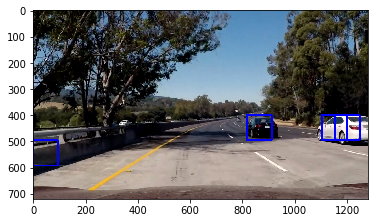

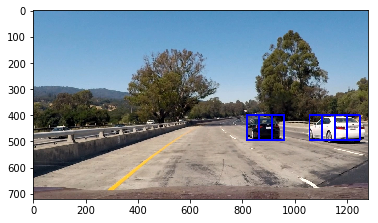

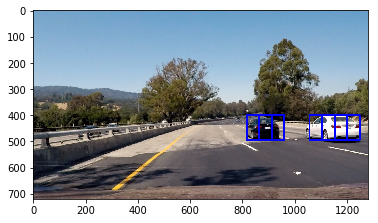

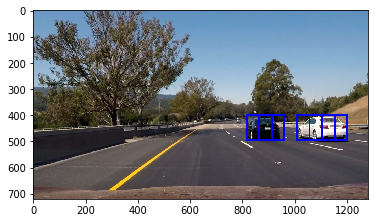

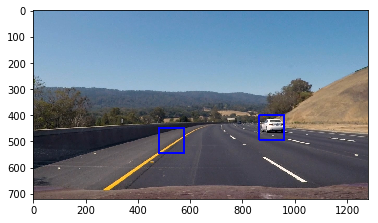

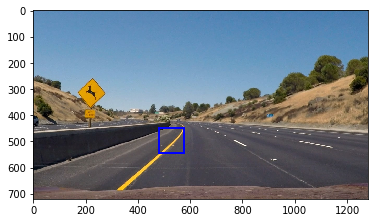

In [253]:
ystart = 400
ystop = 656
scale = 1.5
spatial_size=(32,32)
hist_bins=32

test_images = glob.glob('./test_images/test*.jpg')

for test_image in test_images:
    test_image = mpimg.imread(test_image)
    out_img, bbox = find_cars(test_image, ystart, ystop, scale, 
                        svc, X_scaler, orient, pix_per_cell, 
                        cell_per_block, spatial_size, hist_bins)
    plt.figure()
    plt.imshow(out_img)

### Find Optimal Parameters

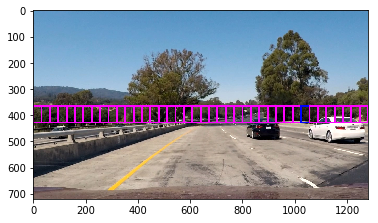

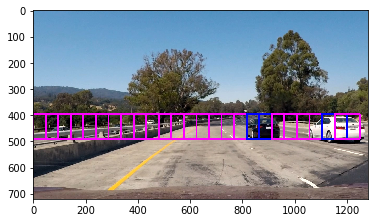

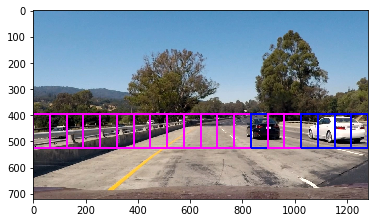

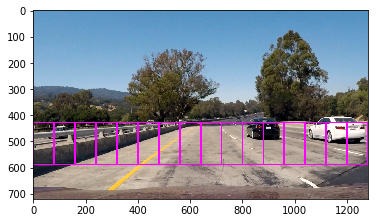

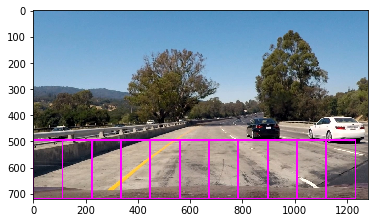

In [254]:
test_image = mpimg.imread('./test_images/test1.jpg')

ystart = 364
ystop = 428
scale = 1.0
out_img, _ = find_cars(test_image, ystart, ystop, scale, 
                            svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size=(32,32), hist_bins=32, viz_win=True)
plt.figure()
plt.imshow(out_img)

ystart = 396
ystop = 396+96
scale = 1.5
out_img, _ = find_cars(test_image, ystart, ystop, scale, 
                            svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size=(32,32), hist_bins=32, viz_win=True)
plt.figure()
plt.imshow(out_img)

ystart = 396
ystop = 396+128
scale = 2
out_img, _ = find_cars(test_image, ystart, ystop, scale, 
                            svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size=(32,32), hist_bins=32, viz_win=True)
plt.figure()
plt.imshow(out_img)

ystart = 428
ystop = 428+196
scale = 2.5
out_img, _ = find_cars(test_image, ystart, ystop, scale, 
                            svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size=(32,32), hist_bins=32, viz_win=True)
plt.figure()
plt.imshow(out_img)

ystart = 496
ystop = 496+256
scale = 3.5
out_img, _ = find_cars(test_image, ystart, ystop, scale, 
                            svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size=(32,32), hist_bins=32, viz_win=True)
plt.figure()
plt.imshow(out_img)

# 6. Heatmap

In [255]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        #print(box)
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

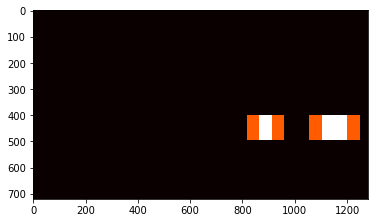

In [256]:
# Test heatmap on random test image
ystart = 400
ystop = 656
scale = 1.5

test_image = mpimg.imread('./test_images/test1.jpg')
out_img, bbox = find_cars(test_image, ystart, ystop, scale, 
                            svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size=(32,32), hist_bins=32)

heatmap_img = np.zeros_like(test_image[:,:,0])
heatmap_img = add_heat(heatmap_img, bbox)

plt.figure()
plt.imshow(heatmap_img, cmap='hot')

### Apply Threshold to Reduce False-Positives

In [257]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [258]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

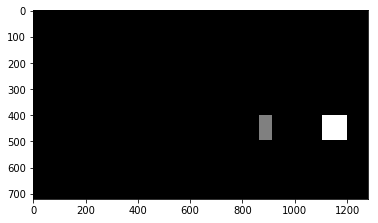

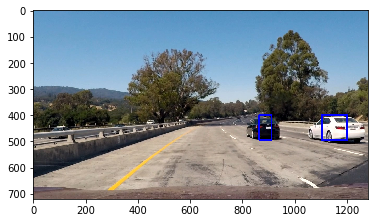

In [263]:
# Apply threshold to help remove false positives
heat = apply_threshold(heatmap_img,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)

#print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

plt.figure()
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)
# Display the image
plt.imshow(draw_img)


## 7. Define Pipeline Handling Function

In [264]:
# Define function handle for Single Frame Info
def process_image(image):

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    sum_bbox=[]
    bbox=[]
    
    ystart = 400
    ystop = 464
    scale = 1.0
    out_img, bbox = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size=(32,32), hist_bins=32)
    if len(bbox)>0: sum_bbox.append(bbox)

    ystart = 400
    ystop = 496
    scale = 1.5
    out_img, bbox = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size=(32,32), hist_bins=32)
    if len(bbox)>0: sum_bbox.append(bbox)

    ystart = 400
    ystop = 528
    scale = 2.0
    out_img, bbox = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size=(32,32), hist_bins=32)
    if len(bbox)>0: sum_bbox.append(bbox)

    ystart = 400
    ystop = 596
    scale = 3.5
    out_img, bbox = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size=(32,32), hist_bins=32)
    if len(bbox)>0: sum_bbox.append(bbox)

    sum_bbox = [item for sublist in sum_bbox for item in sublist] #flatten list
    
    heatmap_img = np.zeros_like(image[:,:,0])
    heatmap_img = add_heat(heatmap_img, sum_bbox)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    #print(labels[1], 'cars found')
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

### Process Test Video without Frame-to-Frame info

In [265]:
# Process video
output = 'test_video_output.mp4'
clip = VideoFileClip("test_video.mp4")

out_clip = clip.fl_image(process_image)
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4



 97%|█████████▋| 38/39 [00:06<00:00,  6.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 6.14 s, sys: 122 ms, total: 6.26 s
Wall time: 6.99 s


In [266]:
# Process video
output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")

out_clip = clip.fl_image(process_image)
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 12%|█▏        | 152/1261 [00:24<02:50,  6.50it/s]


 24%|██▍       | 303/1261 [00:49<02:47,  5.73it/s]


 36%|███▌      | 454/1261 [01:14<02:14,  6.01it/s]


 48%|████▊     | 605/1261 [01:39<01:53,  5.80it/s]


 60%|█████▉    | 756/1261 [02:04<01:22,  6.12it/s]


 72%|███████▏  | 907/1261 [02:28<00:57,  6.11it/s]


 84%|████████▍ | 1057/1261 [02:53<00:33,  6.06it/s]


 96%|█████████▌| 1205/1261 [03:18<00:08,  6.32it/s]


100%|█████████▉| 1260/1261 [03:27<00:00,  5.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 23s, sys: 2.08 s, total: 3min 26s
Wall time: 3min 28s


## 8. Frame-to-Frame Information

In [268]:
# Use class instead of global variable to store frame-to-frame info
class Bbox_Detect():
    def __init__(self):
        self.bbox = [] 
        
    def add_box(self, bbox):
        self.bbox.append(bbox)
        if len(self.bbox) > 20:
            self.bbox.pop(0)

In [273]:
# Define function handle for Single Frame Info
def process_video(image):

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    sum_bbox=[]
    bbox=[]
    
    ystart = 400
    ystop = 464
    scale = 1.0
    out_img, bbox = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size=(32,32), hist_bins=32)
    if len(bbox)>0: sum_bbox.append(bbox)

    ystart = 400
    ystop = 496
    scale = 1.5
    out_img, bbox = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size=(32,32), hist_bins=32)
    if len(bbox)>0: sum_bbox.append(bbox)

    ystart = 400
    ystop = 528
    scale = 2.0
    out_img, bbox = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size=(32,32), hist_bins=32)
    if len(bbox)>0: sum_bbox.append(bbox)

    ystart = 400
    ystop = 596
    scale = 3.5
    out_img, bbox = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size=(32,32), hist_bins=32)
    if len(bbox)>0: sum_bbox.append(bbox)
    
    sum_bbox = [item for sublist in sum_bbox for item in sublist] #flatten list
    
    # Append bbox
    if len(sum_bbox) > 0:
        bbox_detect.add_box(sum_bbox)

    heatmap_img = np.zeros_like(image[:,:,0])
    for bbox in bbox_detect.bbox:
        heatmap_img = add_heat(heatmap_img, bbox)
    
    heatmap_img = apply_threshold(heatmap_img, 1+len(bbox_detect.bbox)) #adjust the threshold with min 1
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [274]:
# Process video
output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")

bbox_detect = Bbox_Detect()

out_clip = clip.fl_image(process_video)
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 12%|█▏        | 152/1261 [00:24<02:50,  6.52it/s]


 24%|██▍       | 303/1261 [00:49<02:45,  5.78it/s]


 36%|███▌      | 454/1261 [01:14<02:08,  6.30it/s]


 48%|████▊     | 605/1261 [01:40<01:56,  5.61it/s]


 60%|█████▉    | 756/1261 [02:04<01:22,  6.13it/s]


 72%|███████▏  | 907/1261 [02:29<00:58,  6.00it/s]


 84%|████████▍ | 1057/1261 [02:55<00:36,  5.67it/s]


 96%|█████████▌| 1205/1261 [03:19<00:09,  5.81it/s]


100%|█████████▉| 1260/1261 [03:28<00:00,  5.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 24s, sys: 2.23 s, total: 3min 27s
Wall time: 3min 29s
